In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Panel Data Version

### Panel Data of Rents

In [2]:
home_prices = pd.read_csv('../data/efz/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [3]:
home_prices = home_prices[home_prices.City == 'San Francisco']
annual = [c for c in home_prices.columns if '12-31' in c]
neighborhood_rents = home_prices[['RegionName'] + annual].copy()
neighborhood_rents.rename(columns={'RegionName': 'neighborhood'}, inplace=True)

In [4]:
covered_years = neighborhood_rents.columns[1:].str.split('-').str[0].astype(int) + 1

In [5]:
neighborhood_rents.columns = ['neighborhood'] + covered_years.tolist()
neighborhood_rents = neighborhood_rents.melt(id_vars='neighborhood', var_name='year', value_name='rent')
neighborhood_rents = neighborhood_rents[(neighborhood_rents.year >= 2007) & (neighborhood_rents.year < 2017)]

In [8]:
neighborhood_rents.neighborhood.nunique()

108

Geospatial version

In [9]:
neigh = gpd.read_file('../data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp')

In [10]:
sf = neigh[neigh.CITY.str.contains('San Francisco')]
sf_neighborhoods = sf[['NAME', 'geometry']]
sf_neighborhoods = sf_neighborhoods.rename(columns={'NAME': 'zillow_neighborhood_name'})
sf_neighborhoods = sf_neighborhoods.replace({'zillow_neighborhood_name': {
    'Marina' : 'Marina District',
    'Haight-Ashbury': 'Haight',
    'South Of Market': 'South of Market',
    'Ocean View': 'Oceanview',
    'Castro-Upper Market': 'Castro',
    'Twin Peaks': 'Clarendon Heights',
    'West Of Twin Peaks': 'Forest Knolls'
}})

<Axes: >

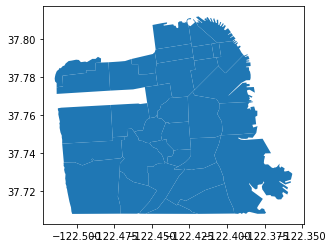

In [11]:
sf_neighborhoods.plot()

### Median sf per home per year in neighborhood

In [12]:
tax = gpd.read_feather('../data/tax.geofeather')

In [13]:
tax = tax[tax.closed_roll_year < 2017].copy()

In [14]:
residential = tax[tax.use_definition.str.contains('Residential') | False]
residential = residential[residential['number_of_units'] > 0]
residential = residential[residential['property_area'] > 0]

In [15]:
# this line is expensive to run
residential = residential.to_crs(epsg=3310).sjoin_nearest(sf_neighborhoods.to_crs(epsg=3310), how='left')

In [16]:
residential = residential.drop(columns='index_right')

In [17]:
residential.analysis_neighborhood.nunique()

40

In [18]:
residential['home_size1'] = residential['property_area'] / residential['number_of_units']

In [19]:
sf_by_neighborhood = residential.groupby(['zillow_neighborhood_name', 'closed_roll_year']).agg({'home_size1':'median'})

In [20]:
sf_by_neighborhood = sf_by_neighborhood.reset_index()

In [21]:
sf_by_neighborhood.value_counts('zillow_neighborhood_name')

zillow_neighborhood_name
Bayview               10
Pacific Heights       10
Noe Valley            10
North Beach           10
Oceanview             10
Outer Mission         10
Outer Richmond        10
Outer Sunset          10
Parkside              10
Bernal Heights        10
Potrero Hill          10
Presidio Heights      10
Russian Hill          10
Seacliff              10
South of Market       10
Visitacion Valley     10
Nob Hill              10
Mission               10
Marina District       10
Lakeshore             10
Inner Sunset          10
Inner Richmond        10
Haight                10
Glen Park             10
Forest Knolls         10
Financial District    10
Excelsior             10
Downtown              10
Crocker Amazon        10
Clarendon Heights     10
Chinatown             10
Castro                10
Western Addition      10
Diamond Heights        9
Name: count, dtype: int64

In [22]:
sf_by_neighborhood

,zillow_neighborhood_name,closed_roll_year,home_size1
0,Bayview,2007,1254.000000
1,Bayview,2008,1255.000000
2,Bayview,2009,1259.000000
3,Bayview,2010,1261.000000
4,Bayview,2011,1270.000000
...,...,...,...
334,Western Addition,2012,1078.166667
335,Western Addition,2013,1080.000000
336,Western Addition,2014,1080.000000
337,Western Addition,2015,1078.000000


In [27]:
residential.zillow_neighborhood_name.isin(neighborhood_rents.neighborhood).mean()

0.9999077214556005

### Match Zillow neighborhoods with SF

In [28]:
neighborhood_rents

,neighborhood,year,rent
648,Outer Sunset,2007,7.825451e+05
649,Mission,2007,6.568030e+05
650,South of Market,2007,6.538900e+05
651,Outer Richmond,2007,8.857205e+05
652,Parkside,2007,8.434290e+05
...,...,...,...
1723,Balboa Terrace,2016,1.836078e+06
1724,Fisherman's Wharf,2016,1.091039e+06
1725,St. Francis Wood,2016,2.573600e+06
1726,Monterey Heights,2016,2.245639e+06


In [29]:
sf_by_neighborhood

,zillow_neighborhood_name,closed_roll_year,home_size1
0,Bayview,2007,1254.000000
1,Bayview,2008,1255.000000
2,Bayview,2009,1259.000000
3,Bayview,2010,1261.000000
4,Bayview,2011,1270.000000
...,...,...,...
334,Western Addition,2012,1078.166667
335,Western Addition,2013,1080.000000
336,Western Addition,2014,1080.000000
337,Western Addition,2015,1078.000000


In [30]:
rents_by_sf_by_hood = pd.merge(sf_by_neighborhood, neighborhood_rents,
                               right_on=['neighborhood', 'year'], 
                               left_on=['zillow_neighborhood_name', 'closed_roll_year'], 
                               how='left')

In [31]:
rents_by_sf_by_hood

,zillow_neighborhood_name,closed_roll_year,home_size1,neighborhood,year,rent
0,Bayview,2007,1254.000000,Bayview,2007,651657.844415
1,Bayview,2008,1255.000000,Bayview,2008,632326.903397
2,Bayview,2009,1259.000000,Bayview,2009,507883.932749
3,Bayview,2010,1261.000000,Bayview,2010,402944.747816
4,Bayview,2011,1270.000000,Bayview,2011,399162.834064
...,...,...,...,...,...,...
334,Western Addition,2012,1078.166667,Western Addition,2012,499100.008186
335,Western Addition,2013,1080.000000,Western Addition,2013,583883.776004
336,Western Addition,2014,1080.000000,Western Addition,2014,676851.275611
337,Western Addition,2015,1078.000000,Western Addition,2015,793448.061165


In [32]:
rents_by_sf_by_hood['rent/sf'] = (rents_by_sf_by_hood['rent'] / rents_by_sf_by_hood['home_size1']).round(0)

In [33]:
rents_by_sf_by_hood['rent/sf']

0      520.0
1      504.0
2      403.0
3      320.0
4      314.0
       ...  
334    463.0
335    541.0
336    627.0
337    736.0
338    880.0
Name: rent/sf, Length: 339, dtype: float64

### Impute annual mean. Do better matching later

In [34]:
rents_by_sf_by_hood = rents_by_sf_by_hood.drop(columns=['neighborhood', 'year'])

In [35]:
rents_by_sf_by_hood.rent.isna().mean()

0.011799410029498525

In [36]:
year_avg = rents_by_sf_by_hood.groupby('closed_roll_year').agg({'rent/sf': 'mean'})

In [37]:
year_avg.loc[2007]

rent/sf    707.46875
Name: 2007, dtype: float64

In [38]:
for yr in range(2007, 2017):
    rents_by_sf_by_hood.loc[rents_by_sf_by_hood.closed_roll_year == yr, 'rent/sf'] = rents_by_sf_by_hood.loc[rents_by_sf_by_hood.closed_roll_year == yr, 'rent/sf'].fillna(year_avg.loc[yr][0])

In [39]:
rents_by_sf_by_hood.to_csv('../data/panel_rent_per_sf_per_neighborhood.csv')

<Axes: >

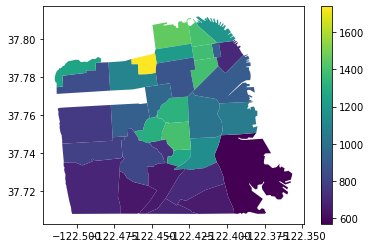

In [40]:
tmp = pd.merge(sf_neighborhoods, rents_by_sf_by_hood)
tmp.query('closed_roll_year == 2016').plot(column = 'rent/sf', legend=True)